# PROMPT CHAINING

Prompt chaining is a technique in NLP where "multiple prompts are sequences together a model through a complex task or reasoning process". 

Instead of relying on a single prompt to achieve a desired outcome, prompt chaining breaks the task into smaller, manageable steps, with each step building on the previous one. 

This approach can improve accuracy, coherence, and control when working with Large Language Models.

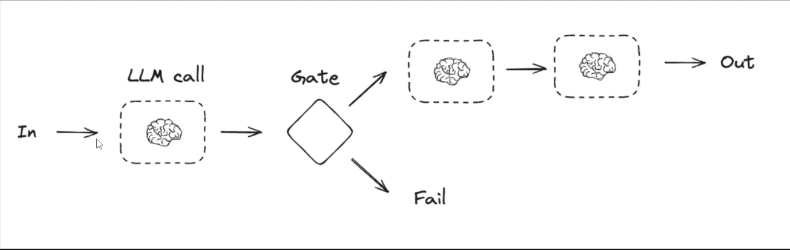

Prompt chaining is a technique in NLP where multiple prompts are sequenced together to guide a model through a complex task or reasoning process.. Instead of relying on a single prompt to achieve a desired outcome, prompt chaining breaks the task into smaller, manageable steps, with each step building on the previous one. This approach can improve accuracy, coherence, and control when working with large language models. LangGraph, is a framework designed to facilitate structured interactions with language models, making in an excellent tool for implementing prompt cleaning. It allows you to define a graph of nodes (representing individual prompts or tasks) and edges (representing the flow of information b/n them). This structure enables dynamic, multi-step conversations or workflows, where the output of one node can feed into the input of the next.

# How prompt chaining works with LangGraph

1. Define the Task: Startby breaking down the problem into smaller sub-tasks. for example, if you want to generate a detailed report,you mght split it into steps like "gather data", "analyze data" and "write summary".

2. Create Nodes: Each sub-task becomes a node in the LangGraph structure. A node could be a prompt that instructs the model to perform a specific action, such as "List key facts about X" or "Summarize the following text".

3. Establish Edges: Edges define the sequence and dependencies between nodes. for instance, the output of the "gather data" node flows into the "analyze data" node, ensuring the model has the necessary context to proceed.

4. Execute the Graph: LangGraph processes the nodes in order, passing information along the edges. The model generates responses step-by-step, refining the output as it progresses through the chain.

5. Iterate if Needed: LangGraph supports conditional logic and loops. so you van revisit earlier nodes or adjust the flow based on intermediate results.

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model = "llama-3.1-8b-instant")

result = llm.invoke("Hello")

result

AIMessage(content='Hello. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 36, 'total_tokens': 46, 'completion_time': 0.010669908, 'prompt_time': 0.00155013, 'queue_time': 0.04287777, 'total_time': 0.012220038}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ab04adca7d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--22775528-4870-4d9a-9962-5e3dad0b9d15-0', usage_metadata={'input_tokens': 36, 'output_tokens': 10, 'total_tokens': 46})

In [26]:
from pydantic import BaseModel
from langgraph.graph import START, END, StateGraph
from IPython .display import Image, display

# State graph
class State(BaseModel):
    topic: str
    story: str = ''
    improved_story: str = ''
    final_story: str = ''


In [27]:
# Nodes

def generate_story(state: State):
    msg = llm.invoke(f"write a one sentence premise about {state.topic}")
    return {"story": msg.content}


def check_conflict(state: State):
    if '?' in state.story or '!' in state.story:
        return 'Fail'
    return 'Pass'

def improved_story(state: State):
    msg = llm.invoke(f"Enhance this story premise with vivid details: {state.story}")
    return {"improved_story": msg.content}

def polish_story(state: State):
    msg = llm.invoke(f"Add an unexpected twist to this story premise: {state.improved_story}") 
    return {"final_story": msg.content}

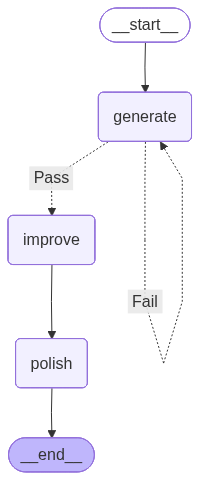

In [28]:
# Build the graph

graph = StateGraph(State)

graph.add_node("generate", generate_story)
graph.add_node("improve", improved_story)
graph.add_node("polish", polish_story)

# Define the edges
graph.add_edge(START, "generate")
graph.add_conditional_edges("generate", check_conflict, {"Pass": "improve", 'Fail':'generate'})
graph.add_edge("improve", 'polish')
graph.add_edge('polish', END)


# compile the graph
compiled_graph = graph.compile()

# visualize the graph
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [29]:
# Run the graph

state = {'topic': "Naruto anime"}
result = compiled_graph.invoke(state)
result

{'topic': 'Naruto anime',
 'story': 'In the village of Konohagakure, a young ninja named Naruto Uzumaki embarks on a journey to become the Hokage, the leader of his village, while learning the true meaning of friendship, sacrifice, and the power of the nine-tailed beast within him.',
 'improved_story': "In the heart of the Hidden Leaf Village, Konohagakure, where cherry blossoms bloomed in vibrant hues against the serene mist-shrouded mountains, a young ninja named Naruto Uzumaki was born with a burning ambition. His eyes gleamed like the morning sun as he gazed up at the Hokage's Tower, the very symbol of his ultimate goal: to become the respected leader of his village, the Hokage.\n\nNaruto's life was far from ordinary. He was the jinchuriki, the human host, to the nine-tailed beast, Kurama, a powerful and ancient creature that had been sealed within him at birth. The villagers, still wary of the Nine-Tails' destructive power, had ostracized Naruto, labeling him a monster. However, N

# Benefits of prompt chaining with langgraph

- Improved Context Management: By breaking tasks into smaller prompts, the model can focus on one aspect at a time, reducing the risk of losing context in long inputs.

- Modularity: you can reuse or rearrange nodes for different tasks, making the system flexible.

- Debugging: If something goes wrong. it's easier to pinpoint which step failed and adjust the prompt or logic accordingly.

- Complex Reasoning: Chaining prompts allows the model to "think" step-by-step, mimicking human problem-solving more effectively.